# Operability Analysis of Sewage Sludge Gasification using Aspen Plus and Opyrability

This notebook demonstrates how to connect an Aspen Plus process simulation with Python to perform operability analysis using the opyrability library. A sewage sludge gasification model will be used as an example, but the connection methods shown here can be applied to any Aspen Plus simulation.

The model we're using simulates a fluidized-bed gasifier based on the work by de Andrés et al. (2019). It converts sewage sludge into syngas while also producing some tar (modeled as naphtalene) as an undesirable byproduct. It utilizes a non-stoichiometric equilibrium approach based on Gibbs free energy minimization, calibrated with restricted equilibrium against experimental data, to predict gasification products under various operating conditions.

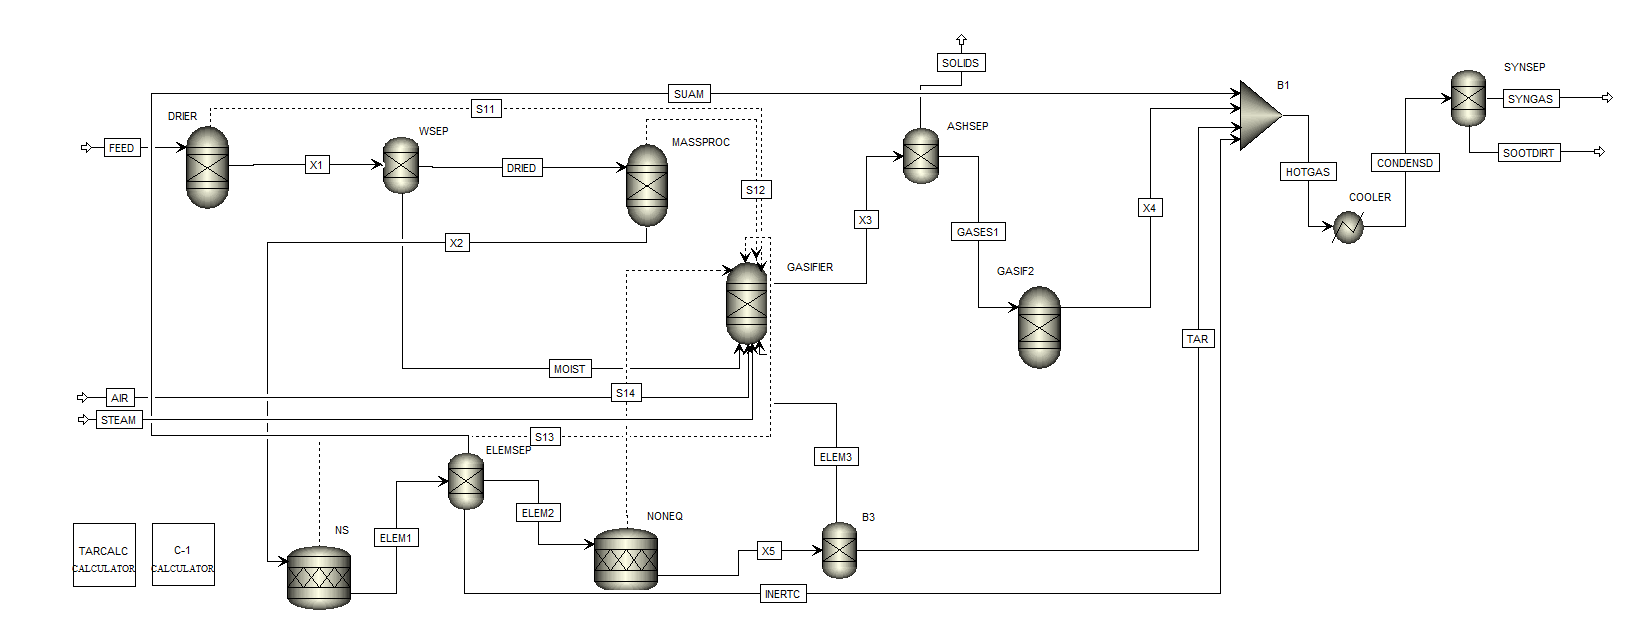

*Figure 1: Aspen Plus flowsheet for the gasification process (de Andrés et al., 2019)*

The analysis performs forward mapping:

| Input (AIS)                | Output (AOS)                 |
|---------------------------|------------------------------|
| Temperature (T) [K]       | Syngas LHV [MJ/Nm³]          |
| Equivalence Ratio (ER)    | Tar Production [g/Nm³]       |
| SB (fixed at 0.5)         |                              |

This will reveal the achievable performance space and highlight the trade-offs between the outputs.

**Requirements:** This notebook requires a working installation and license of Aspen Plus on a Windows machine, along with the necessary Python libraries (`opyrability`, `numpy`, `matplotlib`, `pywin32`).

Let's start by importing the necessary libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import win32com.client
import time
from opyrability import AIS2AOS_map, multimodel_rep

The first step is to establish a connection to Aspen Plus and load the gasifier simulation. Replace the simulation_path with the correct path to your Aspen file (.apw or .bkp).

In [2]:
# Connect to Aspen Plus
aspen = win32com.client.Dispatch('Apwn.Document')

# Load the simulation file
simulation_path = r"G:\My Drive\doutorado\gasifier\20250324\aspen_files\20250324_2.apw"
aspen.InitFromArchive2(simulation_path)
aspen.Visible = 1  # Make Aspen visible
aspen.SuppressDialogs = 1  # Suppress dialog pop-ups

print("Connected to Aspen Plus successfully")

Connected to Aspen Plus successfully


Now let's define our process model function that interfaces with Aspen Plus. This function takes the input parameters (temperature and equivalence ratio), sets them in the Aspen simulation, runs the model, and extracts the outputs we're interested in.

**Important:** The Aspen variable paths inside this function (`"\Data\Blocks\..."`) are specific to the flowsheet structure and must be verified and updated to match your model. The node paths can be verified in Aspen at Customize tab > Variable Explorer.

In [3]:
def gasifier_problem(u):
    """
    Gasifier model function that interacts with Aspen Plus.
    
    Args:
        u: Input vector [temperature, equivalence_ratio]
    
    Returns:
        y: Output vector [syngas_LHV, tar_production]
    """
    # Reset simulation
    aspen.Reinit()
    time.sleep(1)  # Brief pause after reset
    
    # Extract input parameters
    temperature = u[0]  # Temperature (K)
    er = u[1]          # Equivalence ratio
    sb = 0.5           # Fixed steam-to-biomass ratio
    
    # Set parameters in Aspen Plus
    aspen.Tree.FindNode(r"\Data\Blocks\GASIF2\Input\TEMP").Value = temperature
    aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Calculator\C-1\Input\FVN_INIT_VAL\ER").Value = er
    aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Calculator\C-1\Input\FVN_INIT_VAL\SB").Value = sb
    
    # Run simulation
    aspen.Engine.Run2()
    while aspen.Engine.IsRunning:
        time.sleep(0.5)  # Check every half second
     
    # Check convergence status
    aux_conv = aspen.Tree.FindNode(r"\Data\Results Summary\Run-Status\Output\UOSSTAT2").Value
    
    # Only process results if simulation converged successfully
    if aux_conv == 8:  # 8 = successful completion
        # Get syngas composition
        H2 = aspen.Tree.FindNode(r"\Data\Streams\SYNGAS\Output\MOLEFRAC\MIXED\HYDRO-01").Value
        CH4 = aspen.Tree.FindNode(r"\Data\Streams\SYNGAS\Output\MOLEFRAC\MIXED\METHA-01").Value
        CO = aspen.Tree.FindNode(r"\Data\Streams\SYNGAS\Output\MOLEFRAC\MIXED\CARBO-01").Value
        
        # Calculate syngas LHV (MJ/Nm³)
        syngas_LHV = H2 * 10.8 + CO * 12.6 + CH4 * 35.8
        
        # Read tar mass flow (kg/hr)
        tar_mass_flow = aspen.Tree.FindNode(r"\Data\Streams\SOOTDIRT\Output\MASSFLOW\MIXED\NAPHT-01").Value
        
        # Read syngas volume flow (L/min) - fixed path
        syngas_vol_flow = aspen.Tree.FindNode(r"\Data\Streams\SYNGAS\Output\VOLFLMX\MIXED").Value
        
        # Convert syngas volume flow: L/min --> Nm³/hr
        syngas_vol_Nm3 = syngas_vol_flow * 60 / 1000
        
        # Compute tar production in g/Nm³
        if syngas_vol_Nm3 > 0:
            tar_production = (tar_mass_flow * 1000) / syngas_vol_Nm3
        else:
            tar_production = 0
        
        return np.array([syngas_LHV, tar_production])
    else:
        # Return zeros if simulation didn't converge
        return np.zeros(2)

Before running a full operability analysis, let's test our interface function with a single set of input parameters to make sure it works correctly.

In [4]:
# Test the function with a single set of inputs
test_inputs = np.array([1073.15, 0.3])  # 800°C, ER=0.3
test_outputs = gasifier_problem(test_inputs)

print(f"Test inputs: Temperature = {test_inputs[0]} K, ER = {test_inputs[1]}")
print(f"Test outputs: Syngas LHV = {test_outputs[0]:.2f} MJ/Nm³, Tar Production = {test_outputs[1]:.2f} g/Nm³")

Test inputs: Temperature = 1073.15 K, ER = 0.3
Test outputs: Syngas LHV = 3.48 MJ/Nm³, Tar Production = 7.42 g/Nm³


Now that the interface is working, we'll define the Available Input Space (AIS) for our operability analysis. This consists of the ranges we want to explore for temperature and equivalence ratio.

In [5]:
# Define the Available Input Space (AIS) bounds
AIS_bounds = np.array([
    [1023.15, 1123.15],  # Temperature in K (750-850°C)
    [0.2, 0.4]           # Equivalence ratio
])

# Set grid resolution for AIS
resolution = [5, 5]  # 5x5 grid

print(f"Temperature range: {AIS_bounds[0,0]} - {AIS_bounds[0,1]} K")
print(f"Equivalence ratio range: {AIS_bounds[1,0]} - {AIS_bounds[1,1]}")
print(f"Resolution: {resolution[0]} x {resolution[1]} grid = {resolution[0] * resolution[1]} simulations")

Temperature range: 1023.15 - 1123.15 K
Equivalence ratio range: 0.2 - 0.4
Resolution: 5 x 5 grid = 25 simulations


Now we'll use the `AIS2AOS_map` function from the opyrability library to perform forward mapping. This will evaluate our gasifier model at each point in the input grid and collect the corresponding outputs.

Note: This step will run the Aspen Plus simulation multiple times (resolution[0] × resolution[1] = 25 times with a 5×5 grid), which can take some time.

Computing AIS to AOS mapping...
Elapsed time: 5.94 minutes


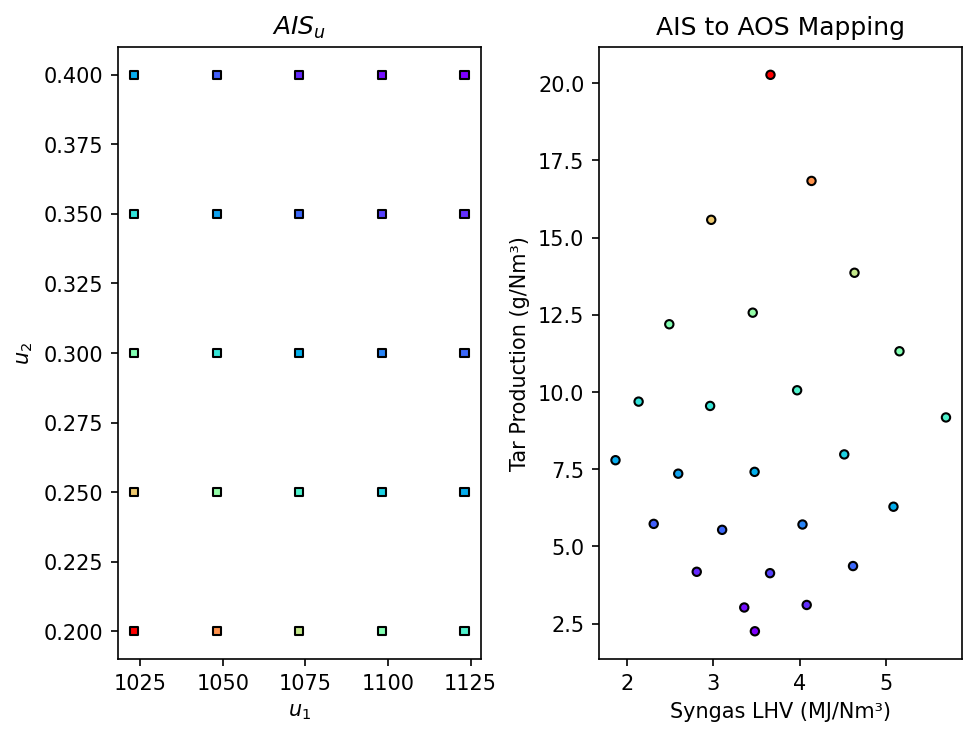

In [6]:
# Generate the AIS to AOS mapping
start_time = time.time()

print("Computing AIS to AOS mapping...")
AIS, AOS = AIS2AOS_map(gasifier_problem, AIS_bounds, resolution, plot=True)

print("Elapsed time: %.2f minutes" % ((time.time() - start_time)/60))

# Show the default plot generated by opyrability
plt.title("AIS to AOS Mapping")
plt.xlabel("Syngas LHV (MJ/Nm³)")
plt.ylabel("Tar Production (g/Nm³)")
plt.show()

The AIS to AOS plots show how temperature and equivalence ratio affect syngas LHV and tar production. They reveal a trade-off where conditions favoring higher LHV also result in more (undesirable) tar. 

We can also generate a visualization of the Achievable Output Space (AOS) using the `multimodel_rep` function from opyrability (takes approximately the same time as the `AIS2AOS_map`).

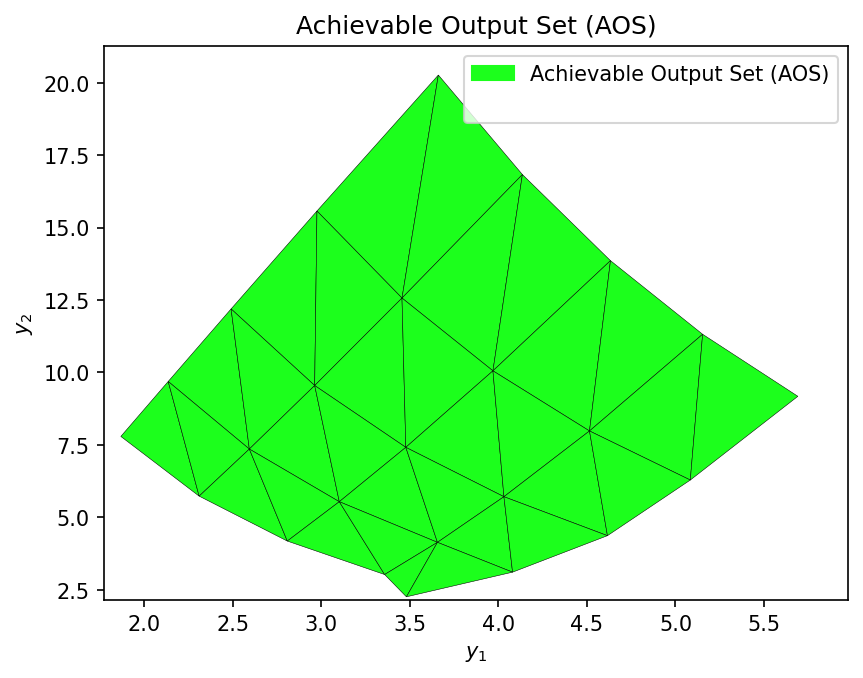

Elapsed time: 6.18 minutes


In [7]:
# Generate the AOS region representation
start_time = time.time()
AOS_region = multimodel_rep(gasifier_problem, AIS_bounds, resolution)

print("Elapsed time: %.2f minutes" % ((time.time() - start_time)/60))

plt.show()

Now that we have the Achievable Output Space (AOS), we can define a Desired Output Space (DOS) and evaluate the Operability Index (OI). The OI quantifies the fraction of the DOS that is achievable by the process given the AIS.

For this gasifier, we define the DOS based on common requirements for syngas utilization (e.g., in engines) and typical tar levels from fluidized bed gasifiers before extensive cleaning:

- Syngas LHV: 4.2 - 6.0 MJ/Nm³
- Tar Production: 2.0 - 10.0 g/Nm³

In [ ]:
from opyrability import OI_eval

DOS_bounds = np.array([
    [4.2, 6.0],  # Syngas LHV [MJ/Nm³]
    [2.0, 10.0]  # Tar Production [g/Nm³]
])

OI = OI_eval(AOS_region, DOS_bounds)

The plot above illustrates the Achievable Output Space (AOS) for the sewage sludge gasifier against the previously defined Desired Output Space (DOS).

The calculated **Operability Index (OI) of XX.XX%** quantifies the portion of the desired LHV and tar production targets that are achievable within the investigated ranges of temperature and equivalence ratio (with SB fixed at 0.5).

This result indicates the extent to which the gasifier can meet the desired performance specifications. The highlighted overlap in the plot shows the specific operating outcomes that satisfy both the process capabilities and the desired targets.

These results help select operating conditions that meet specific requirements for syngas LHV and tar.

This example can be adapted to explore different inputs, objectives, or be applied to other Aspen models.

*Reference: de Andrés, J. M., Vedrenne, M., Brambilla, M., & Rodríguez, E. (2019). Modeling and model performance evaluation of sewage sludge gasification in fluidized-bed gasifiers using Aspen Plus. Journal of the Air & Waste Management Association, 69(1), 23-33.*